In [1]:
import pydicom
import os
import numpy as np
import cv2
import pydicom
from glob import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [29]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
val = pd.read_csv('val.csv')

### Get the original data split (train/val/test) in csv without frame sampling 

In [18]:
def group_patient(df): # Group view labels per patient
    shrinked_df = df.groupby('path').agg({
        'label': 'first',  # Unique views per patient
        'disease': 'first',  # Assumes consistent health status per patient,
        'sample_spacing': 'first',
        'start': 'first',
        'end': 'first',
        'parent_dir': 'first'
    }).reset_index()
    return shrinked_df

In [38]:
def make_csv(df , df_name = 'df', dest_dir=''):
    df.to_csv(os.path.join(dest_dir,f'{df_name}.csv'), index=False)
    print(f"saved {df_name} csv.")

In [21]:
train = group_patient(train)
val = group_patient(val)
test = group_patient(test)

make_csv(train, 'train_original')
make_csv(val, 'val_original')
make_csv(test, 'test_original')

saved train_original csv.
saved val_original csv.
saved test_original csv.


### Resample Images for Under Represented Classes to Balance Dataset


In [26]:
def plot_label_and_disease_distribution(train_df, val_df, test_df, 
                                        view_label_col='view_label', 
                                        disease_col='health_status',
                                        threshold=0.05):
    import matplotlib.pyplot as plt
    import seaborn as sns

    sets = {'Train': train_df, 'Validation': val_df, 'Test': test_df}

    # ============================
    # 1. View Label Distribution
    # ============================

    # Collect view label counts
    view_dist = {}
    for name, df in sets.items():
        view_dist[name] = df[view_label_col].value_counts()

    view_df = pd.DataFrame(view_dist).fillna(0).astype(int)
    view_df_norm = view_df.div(view_df.sum(axis=0), axis=1)

    # Plot absolute counts
    plt.figure(figsize=(14, 6))
    view_df.plot(kind='bar', figsize=(14, 6))
    plt.title('View Label Distribution (Absolute Counts)')
    plt.xlabel('View Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Plot normalized proportions
    plt.figure(figsize=(14, 6))
    view_df_norm.plot(kind='bar', figsize=(14, 6))
    plt.title('View Label Distribution (Normalized)')
    plt.xlabel('View Label')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Highlight underrepresented view labels
    underrepresented_views = (view_df_norm < threshold).any(axis=1)
    if underrepresented_views.any():
        print("⚠️ Underrepresented view labels (proportion < {:.0%} in any set):".format(threshold))
        print(view_df_norm[underrepresented_views])
    else:
        print("✅ All view labels are well represented.")

    

<Figure size 1400x600 with 0 Axes>

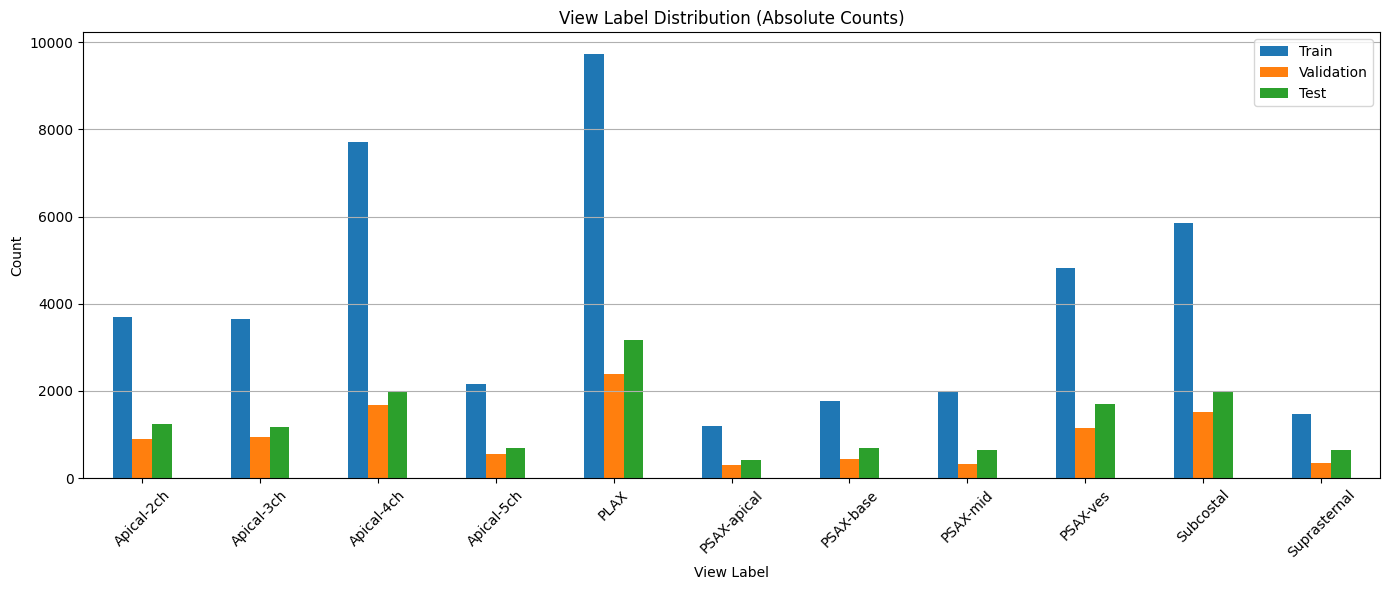

<Figure size 1400x600 with 0 Axes>

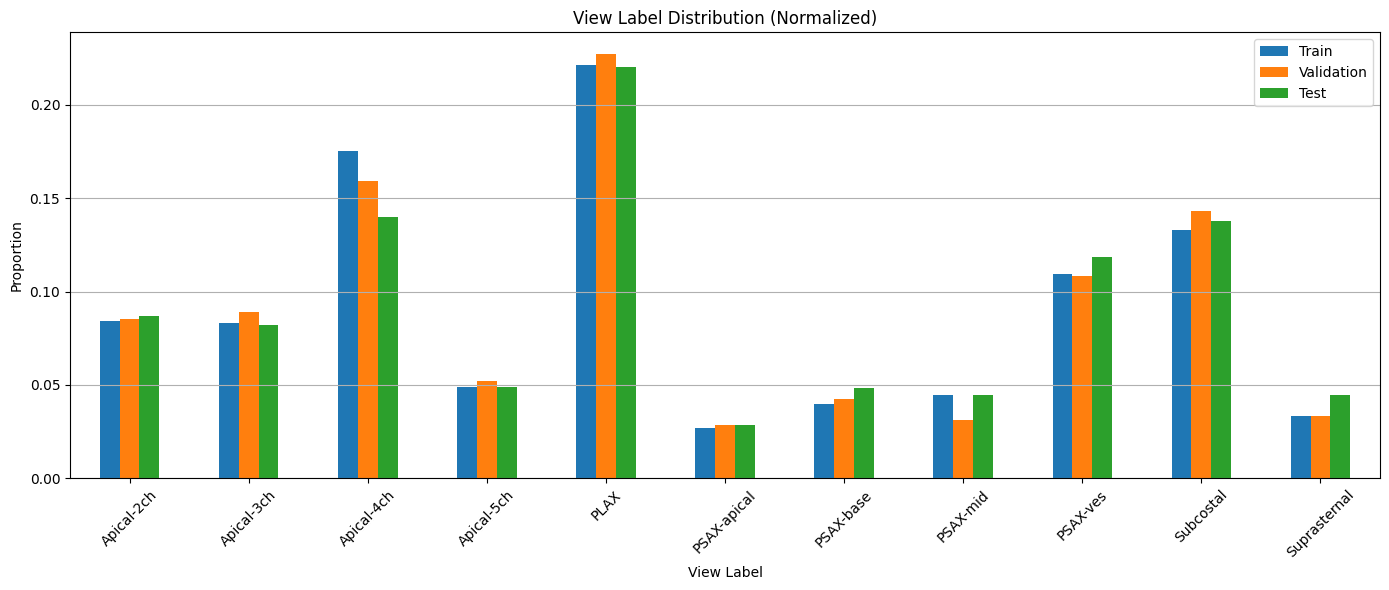

⚠️ Underrepresented view labels (proportion < 5% in any set):
                 Train  Validation      Test
label                                       
Apical-5ch    0.048841    0.052133  0.048747
PSAX-apical   0.027033    0.028436  0.028552
PSAX-base     0.039982    0.042654  0.048050
PSAX-mid      0.044752    0.031280  0.044568
Suprasternal  0.033394    0.033175  0.044568


In [28]:
plot_label_and_disease_distribution(train, val, test, 
                                    view_label_col='label', 
                                    disease_col='disease')

In [34]:
# samples to keep from 10 equally spaced frames 
view_sample_per_video = {
    "PLAX": 1,     # PLAX
    "PSAX-ves": 2,    # PSAX-ves
    "PSAX-base": 5,     # PSAX-base
    "PSAX-mid": 5,     # PSAX-mid
    "PSAX-apical": 7,     # PSAX-apical
    "Apical-2ch": 3,   # Apical-2ch
    "Apical-3ch": 3,   # Apical-3ch
    "Apical-5ch": 5,   # Apical-5ch
    "Apical-4ch": 2,   # Apical-4ch
    "Suprasternal": 5,    # Suprasternal
    "Subcostal": 2    # Subcostal
}

In [35]:
def filter_samples(df, view_sample_per_video= view_sample_per_video):
    selected_rows = []

    # Group by 'path' to process each video separately
    for path, group in df.groupby('path'):
        group = group.sort_values('frame')  # sort by frame index (or other frame indicator)
        label = group['label'].iloc[0]  # get the label for this video
        
        if label in view_sample_per_video:
            n_samples = view_sample_per_video[label]
            total_frames = len(group)
            
            # If fewer frames than requested, take all
            if total_frames <= n_samples:
                selected = group
            else:
                # Select n_samples indices evenly spaced
                indices = np.linspace(0, total_frames - 1, n_samples, dtype=int)
                selected = group.iloc[indices]
            
            selected_rows.append(selected)

    # Concatenate all selected rows into one DataFrame
    return pd.concat(selected_rows, ignore_index=True)


In [36]:
new_train = filter_samples(train)
new_val = filter_samples(val)
new_test = filter_samples(test)

<Figure size 1400x600 with 0 Axes>

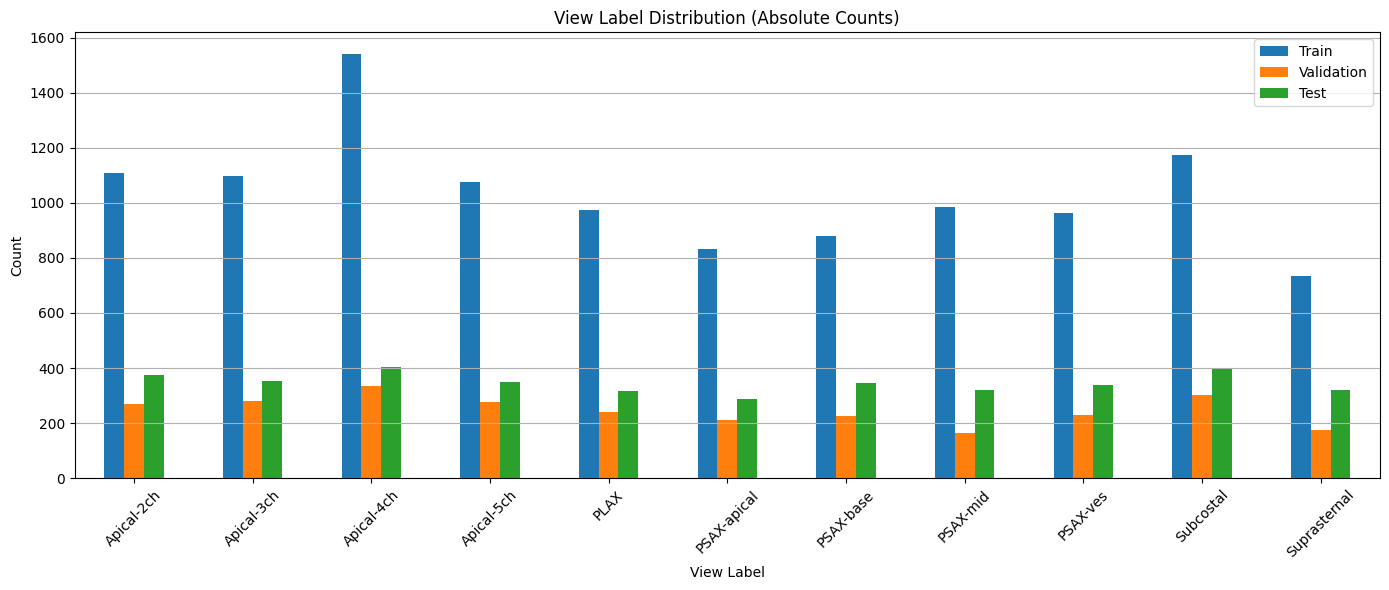

<Figure size 1400x600 with 0 Axes>

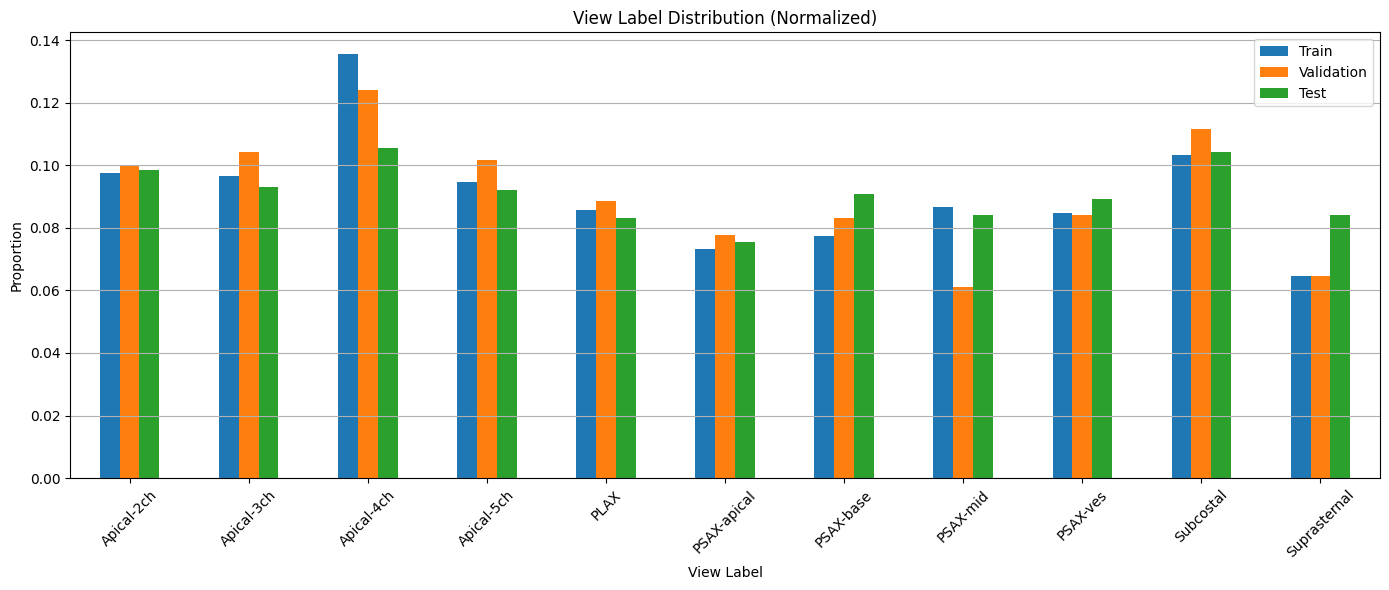

✅ All view labels are well represented.


In [37]:
plot_label_and_disease_distribution(new_train, new_val, new_test, 
                                    view_label_col='label', 
                                    disease_col='disease')

In [39]:
make_csv(new_train, 'train_upsampled')
make_csv(new_val, 'val_upsampled')
make_csv(new_test, 'test_upsampled')

saved train_upsampled csv.
saved val_upsampled csv.
saved test_upsampled csv.
